In [1]:
# STandard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

# Import MAVE-NN
import mavenn

# Import logomaker
import logomaker

# Import helper functions
from helper_functions import my_rsquared, save_fig_with_date_stamp, set_xticks

# Set random seed
np.random.seed(0)

# Set figure name
fig_name = 'fig6'

In [2]:
style_file_name = f'{fig_name}.style'
s = """
axes.linewidth:     0.5     # edge linewidth
font.size:          7.0
axes.labelsize:     7.0  # fontsize of the x any y labels
xtick.labelsize:    7.0  # fontsize of the tick labels
ytick.labelsize:    7.0  # fontsize of the tick labels
legend.fontsize:      7.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
legend.framealpha:    1.0 
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

In [3]:
## Define OtwinowskiGPMapLayer

# Standard TensorFlow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant

# Import base class
from mavenn.src.layers.gpmap import GPMapLayer

# Define custom G-P map layer
class OtwinowskiGPMapLayer(GPMapLayer):
    """
    A G-P map representing the thermodynamic model described by
    Otwinowski (2018).
    """

    def __init__(self, *args, **kwargs):
        """Construct layer instance."""

        # Call superclass constructor
        # Sets self.L, self.C, and self.regularizer
        super().__init__(*args, **kwargs)
        
        # Initialize constant parameter for folding energy
        self.theta_f_0 = self.add_weight(name='theta_f_0',
                                         shape=(1,),
                                         trainable=True,
                                         regularizer=self.regularizer)

        # Initialize constant parameter for binding energy
        self.theta_b_0 = self.add_weight(name='theta_b_0',
                                         shape=(1,),
                                         trainable=True,
                                         regularizer=self.regularizer)

        # Initialize additive parameter for folding energy
        self.theta_f_lc = self.add_weight(name='theta_f_lc',
                                          shape=(1, self.L, self.C),
                                          trainable=True,
                                          regularizer=self.regularizer)

        # Initialize additive parameter for binding energy
        self.theta_b_lc = self.add_weight(name='theta_b_lc',
                                          shape=(1, self.L, self.C),
                                          trainable=True,
                                          regularizer=self.regularizer)

    def call(self, x_lc):
        """Compute phi given x."""

        # 1kT = 0.582 kcal/mol at room temperature
        kT = 0.582

        # Reshape input to samples x length x characters
        x_lc = tf.reshape(x_lc, [-1, self.L, self.C])
        
        # Compute Delta G for binding
        Delta_G_b = self.theta_b_0 + \
                    tf.reshape(K.sum(self.theta_b_lc * x_lc, axis=[1, 2]),
                               shape=[-1, 1])
            
        # Compute Delta G for folding
        Delta_G_f = self.theta_f_0 + \
                    tf.reshape(K.sum(self.theta_f_lc * x_lc, axis=[1, 2]),
                               shape=[-1, 1])
        
        # Compute and return fraction folded and bound
        Z = 1+K.exp(-Delta_G_f/kT)+K.exp(-(Delta_G_f+Delta_G_b)/kT)
        p_bf = (K.exp(-(Delta_G_f+Delta_G_b)/kT))/Z
        phi = p_bf #K.log(p_bf)/np.log(2)
        return phi

In [4]:
# Load GB1 model
model_gb1 = mavenn.load('../models/gb1_thermodynamic_model_2021.12.30.21h.07m')

Model loaded from these files:
	../models/gb1_thermodynamic_model_2021.12.30.21h.07m.pickle
	../models/gb1_thermodynamic_model_2021.12.30.21h.07m.h5


In [5]:
# Load GB1 data
data_df = pd.read_csv('../datasets/gb1_data.csv.gz')

# Split into trainval and test
trainval_df, test_df = mavenn.split_dataset(data_df)

# Compute variational and predictive information
x_test = test_df['x']
y_test = test_df['y']
I_var, dI_var = model_gb1.I_variational(x=x_test, y=y_test)
I_pred, dI_pred = model_gb1.I_predictive(x=x_test, y=y_test, num_subsamples=1000)

# Compute R^2
phi_test = model_gb1.x_to_phi(x=x_test)
yhat_test = model_gb1.phi_to_yhat(phi=phi_test)
r2, dr2 = my_rsquared(yhat_test, y_test)

# Report metrics
print(f'I_var = {I_var:.3f} +- {dI_var:.3f} bits')
print(f'I_pred = {I_pred:.3f} +- {dI_pred:.3f} bits')
print(f'Rsq = {r2:.3f} +- {dr2:.3f}')

Training set   :  477,854 observations (  90.04%)
Validation set :   26,519 observations (   5.00%)
Test set       :   26,364 observations (   4.97%)
-------------------------------------------------
Total dataset  :  530,737 observations ( 100.00%)

I_var = 2.303 +- 0.013 bits
I_pred = 2.357 +- 0.007 bits
Rsq = 0.947 +- 0.001


In [6]:
gb1_seq = model_gb1.x_stats['consensus_seq']
alphabet = model_gb1.alphabet
L = model_gb1.L
C = model_gb1.C

# Load each energy matrix and fix in the wild-type gauge
theta_dict = model_gb1.layer_gpmap.get_params()
theta_f_lc = theta_dict['theta_f_lc']
theta_b_lc = theta_dict['theta_b_lc']

# Get one-hot encoding of wt sequence
wt_ohe = mavenn.src.utils.x_to_ohe(x=gb1_seq, alphabet=alphabet).reshape([L,C])

# Fix each energy matrix in the wild-type gauge
theta_f_lc = theta_f_lc - (theta_f_lc*wt_ohe).sum(axis=1)[:,np.newaxis]
theta_b_lc = theta_b_lc - (theta_b_lc*wt_ohe).sum(axis=1)[:,np.newaxis]

# Test gauge
assert np.all(np.isclose(theta_b_lc*wt_ohe, 0))
assert np.all(np.isclose(theta_f_lc*wt_ohe, 0))

In [7]:
# Get indices for aa order used in Olson et al.
ordered_aa = np.array(list('EDRKHQNSTPGCAVILMFYW'))
ix = ordered_aa.argsort()
sorted_aa = ordered_aa[ix]
ixx = ix.argsort()
sorted_aa[ixx]

array(['E', 'D', 'R', 'K', 'H', 'Q', 'N', 'S', 'T', 'P', 'G', 'C', 'A',
       'V', 'I', 'L', 'M', 'F', 'Y', 'W'], dtype='<U1')

<IPython.core.display.Javascript object>


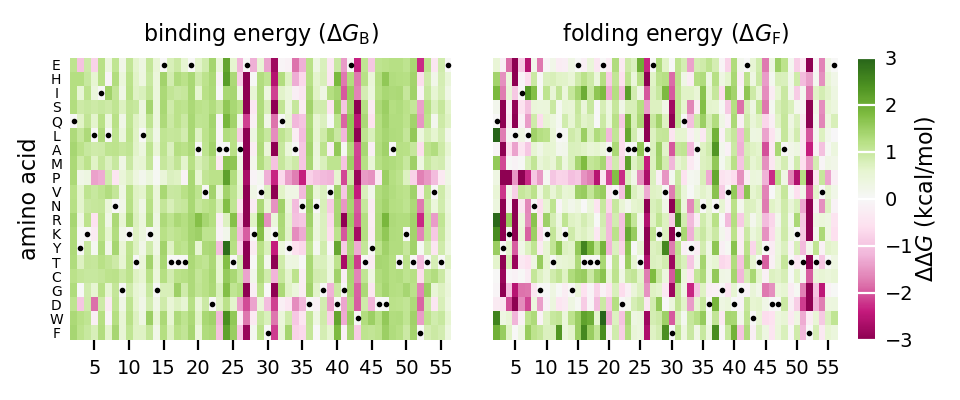

Figure saved figure to png/fig6_panel_b_ipynb_2021.12.31.18h.56m.24s.png.


In [8]:
## heatmaps

# Create two panels
fig, axs = plt.subplots(1, 2, figsize=[4.8,2.0])
fontsize=8.0

# Left panel: draw heatmap illustrating 1pt mutation effects
ax = axs[0]
ax, cb = mavenn.heatmap(-theta_b_lc[:,ixx],
                    alphabet=alphabet[ixx],
                    seq=gb1_seq,
                    clim=[-3,3],
                    cbar=False,
                    seq_kwargs={'s':1,'c':'black'},
                    cmap='PiYG',
                    ccenter=0,
                    ax=ax)
ax.tick_params(labelsize=5, rotation=0, axis='y', length=0, pad=5)
ax.tick_params(rotation=0, axis='x')
set_xticks(ax=ax, L=L, pos_start=2, pos_spacing=5)

#ax.set_xlabel('position',fontsize=fontsize)
ax.set_ylabel('amino acid',fontsize=fontsize,labelpad=3)
#cb.set_label('-$\Delta\Delta G$', rotation=-90, va="bottom",fontsize=fontsize)
ax.set_title('binding energy ($\Delta G_\mathrm{B}$)',fontsize=fontsize)


ax = axs[1]
# Left panel: draw heatmap illustrating 1pt mutation effects
ax, cb1 = mavenn.heatmap(-theta_f_lc[:,ixx],
                        alphabet=alphabet[ixx],
                        seq=gb1_seq,
                        clim=[-3,3],
                        cmap='PiYG',
                        seq_kwargs={'s':1,'c':'black'},                         
                        ccenter=0,
                        ax=ax)
#ax.set_xlabel('position',fontsize=fontsize)
#ax.set_ylabel('amino acid ($c$)',fontsize=fontsize)
cb1.set_label('$\Delta\Delta G$ (kcal/mol)', rotation=90, fontsize=fontsize, labelpad=0)
cb1.set_ticks([-3, -2, -1, 0, 1, 2, 3])
cb1.outline.set_visible(False)
cb1.ax.tick_params(direction='in', size=10, color='white')
ax.set_title('   folding energy ($\Delta G_\mathrm{F}$)',fontsize=fontsize)
ax.tick_params(labelsize=5, rotation=0, axis='y')
ax.set_yticks([])
ax.tick_params(rotation=0, axis='x')
set_xticks(ax=ax, L=L, pos_start=2, pos_spacing=5)

#fig.subplots_adjust(left=3, bottom=1, right=5, top=2, wspace=5, hspace=None)
# Fix up plot
fig.tight_layout(h_pad=1,w_pad=2)

# Save figure
save_fig_with_date_stamp(fig, 'fig6_panel_b', bbox_inches='tight')

In [9]:
# Function to draw logos
def draw_logo(ax, df, ylim=[-1,1], highlight_color='#9981B3', highlight_alpha=0.1):
    xmin = int(df.index.min())
    xmax = int(df.index.max())
    xlim = [xmin-.5, xmax+.5]
    logo = logomaker.Logo(-0.62*df, ax=ax, center_values=True, font_name='Arial Rounded MT Bold')
    ax.set_ylim(ylim)
    ax.set_yticks([ylim[0], 0, ylim[1]])
    logo.style_xticks(anchor=0, spacing=10)
    logo.style_spines(visible=False)
    logo.highlight_position_range(xmin, xmax, alpha=highlight_alpha, color=highlight_color)  
    ax.set_ylabel('$-\Delta \Delta G$ (kcal/mol)', labelpad=-1)
    return logo


In [10]:
# Define sortseqGPMapLayer
from mavenn.src.layers.gpmap import GPMapLayer

# Tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant

class sortseqGPMapLayer(GPMapLayer):
    """
    Represents a four-stage thermodynamic model
    containing the states:
    1. free DNA 
    2. CPR-DNA binding
    3. RNAP-DNA binding
    4. CPR and RNAP both bounded to DNA and interact
    """

    def __init__(self,
                 tf_start,
                 tf_end,
                 rnap_start,
                 rnap_end,
                 *args, **kwargs):
        """Construct layer instance."""

        # Call superclass
        super().__init__(*args, **kwargs)
        
        # set attributes
        self.tf_start = tf_start            # transcription factor starting position
        self.tf_end = tf_end                 # transcription factor ending position
        self.L_tf = tf_end - tf_start        # length of transcription factor
        self.rnap_start = rnap_start         # RNAP starting position
        self.rnap_end = rnap_end             # RNAP ending position
        self.L_rnap = rnap_end - rnap_start  # length of RNAP

        # define bias/chemical potential weight for TF/CRP energy
        self.theta_tf_0 = self.add_weight(name='theta_tf_0',
                                          shape=(1,),
                                          initializer=Constant(1.),
                                          trainable=True,
                                          regularizer=self.regularizer)

        # define bias/chemical potential weight for rnap energy
        self.theta_rnap_0 = self.add_weight(name='theta_rnap_0',
                                            shape=(1,),
                                            initializer=Constant(1.),
                                            trainable=True,
                                            regularizer=self.regularizer)

        # initialize the theta_tf
        theta_tf_shape = (1, self.L_tf, self.C)
        theta_tf_init = np.random.randn(*theta_tf_shape)/np.sqrt(self.L_tf)
        
        # define the weights of the layer corresponds to theta_tf
        self.theta_tf = self.add_weight(name='theta_tf',
                                        shape=theta_tf_shape,
                                        initializer=Constant(theta_tf_init),
                                        trainable=True,
                                        regularizer=self.regularizer)

        # define theta_rnap parameters
        theta_rnap_shape = (1, self.L_rnap, self.C)
        theta_rnap_init = np.random.randn(*theta_rnap_shape)/np.sqrt(self.L_rnap)
        
        # define the weights of the layer corresponds to theta_rnap
        self.theta_rnap = self.add_weight(name='theta_rnap',
                                          shape=theta_rnap_shape,
                                          initializer=Constant(theta_rnap_init),
                                          trainable=True,
                                          regularizer=self.regularizer)

        # define trainable real number G_I, representing interaction Gibbs energy
        self.theta_dG_I = self.add_weight(name='theta_dG_I',
                                   shape=(1,),
                                   initializer=Constant(-4),
                                   trainable=True,
                                   regularizer=self.regularizer)


    def call(self, x):
        """Process layer input and return output.

        x: (tensor)
            Input tensor that represents one-hot encoded 
            sequence values. 
        """
        
        # 1kT = 0.616 kcal/mol at body temperature
        kT = 0.616

        # extract locations of binding sites from entire lac-promoter sequence.
        # for transcription factor and rnap
        x_tf = x[:, self.C * self.tf_start:self.C * self.tf_end]
        x_rnap = x[:, self.C * self.rnap_start: self.C * self.rnap_end]

        # reshape according to tf and rnap lengths.
        x_tf = tf.reshape(x_tf, [-1, self.L_tf, self.C])
        x_rnap = tf.reshape(x_rnap, [-1, self.L_rnap, self.C])

        # compute delta G for crp binding
        G_C = self.theta_tf_0 + \
            tf.reshape(K.sum(self.theta_tf * x_tf, axis=[1, 2]),
                       shape=[-1, 1])

        # compute delta G for rnap binding
        G_R = self.theta_rnap_0 + \
            tf.reshape(K.sum(self.theta_rnap * x_rnap, axis=[1, 2]),
                       shape=[-1, 1])
        
        G_I = self.theta_dG_I

        # compute phi
        numerator_of_rate = K.exp(-G_R/kT) + K.exp(-(G_C+G_R+G_I)/kT)
        denom_of_rate = 1.0 + K.exp(-G_C/kT) + K.exp(-G_R/kT) + K.exp(-(G_C+G_R+G_I)/kT)
        phi = numerator_of_rate/denom_of_rate

        return phi

In [11]:
# Load energy matrices
model_lac = mavenn.load('../models/sortseq_thermodynamic_mpa_2021.12.30.21h.07m')
theta_dict = model_lac.layer_gpmap.get_params()

# Create dataframe for CRP emat
lac_crp_df = pd.DataFrame(columns=model_lac.alphabet, 
                          data=theta_dict['theta_tf'])
lac_crp_df.index = lac_crp_df.index - 74

# Create dataframe for RNAP emat
lac_rnap_df = pd.DataFrame(columns=model_lac.alphabet, 
                           data=theta_dict['theta_rnap'])
lac_rnap_df.index = lac_rnap_df.index - 41

Model loaded from these files:
	../models/sortseq_thermodynamic_mpa_2021.12.30.21h.07m.pickle
	../models/sortseq_thermodynamic_mpa_2021.12.30.21h.07m.h5


<IPython.core.display.Javascript object>


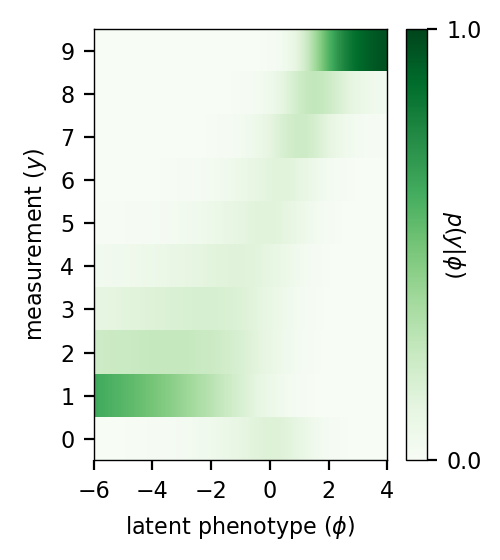

Figure saved figure to png/fig6_panel_d_ipynb_2021.12.31.18h.56m.24s.png.


In [12]:
###
### Panel d
###

fig, ax = plt.subplots(figsize=(2.5,2.8))

# Define helper variables
phi_lim = [-6, 4]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model_lac.Y
y_lim = [-.5, Y-.5]
y_all = list(range(Y))

# Load measurement process
#measurement_process_ss = np.load('../old/lac_emats/measurement_process_ss.npy')
p_of_y_given_phi = model_lac.p_of_y_given_phi(phi=phi_grid, y=y_all, paired=False)

# Plot measurement process
tick_spacing=10
fontsize = 8
im = ax.imshow(p_of_y_given_phi,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               vmax=1.0,
               origin='lower',
               interpolation='nearest',)
ax.set_yticks(y_all)
ax.set_ylabel('measurement ($y$)',fontsize=fontsize)
ax.set_xlabel('latent phenotype ($\phi$)',fontsize=fontsize)
ax.set_xticks([-6, -4, -2,  0, 2, 4])
cb = plt.colorbar(im, **{'format': '%0.1f','ticks': [0, 1],}, ax=ax)
cb.ax.tick_params(labelsize=7.5)
ax.set_aspect('auto')
cb.set_label('$p(y|\phi)$', rotation=-90, va="bottom", fontsize=fontsize, labelpad=-15)
cb.ax.tick_params(labelsize=fontsize)
ax.tick_params(labelsize=fontsize)

# Tighten layout
fig.tight_layout(h_pad=1)

# Save figure
save_fig_with_date_stamp(fig, 'fig6_panel_d', bbox_inches='tight')

<IPython.core.display.Javascript object>


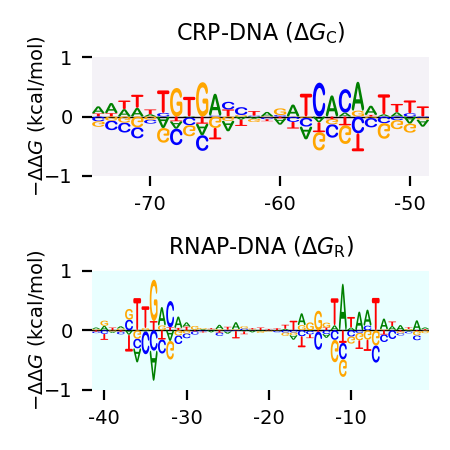

Figure saved figure to png/fig6_panel_e_ipynb_2021.12.31.18h.56m.26s.png.


In [13]:
###
### Panel e
###

fig, axs = plt.subplots(2,1,figsize=[2.25,2.25])

# CRP logo
ax = axs[0]
lac_crp_logo = draw_logo(ax=ax, 
                         df=-lac_crp_df, 
                         ylim=[-1,1],
                         highlight_color='#9981B3', 
                         highlight_alpha=0.1)
ax.set_title("CRP-DNA ($\Delta G_\mathrm{C}$)", fontsize=8)

# RNAP logo
ax = axs[1]
lac_rnap_logo = draw_logo(ax=ax, 
                          df=-lac_rnap_df, 
                          ylim=[-1,1],
                          highlight_color='lightcyan', 
                          highlight_alpha=0.7)
ax.set_title("RNAP-DNA ($\Delta G_\mathrm{R}$)", fontsize=8)

# Save and show figure
# fig.tight_layout(h_pad=1)
# fig.savefig('png/fig6_panel_e.png',dpi=300, facecolor='white')
# plt.show()

# Tighten layout
fig.tight_layout(h_pad=1)

# Save figure
save_fig_with_date_stamp(fig, 'fig6_panel_e', bbox_inches='tight')

In [14]:
# Compute parameter uncertainty
import glob
models = []
for model_num in range(20):
    file_name = f'../models/sortseq_thermodynamic_mpa_model_{model_num}_2021.12.30.21h.07m'
    model = mavenn.load(file_name, verbose=False)
    models.append(model)
    
# Once Mahdi retrains models using the fixed custom layer, refer to parameter by name
dGs = np.array([model.layer_gpmap.get_params()['theta_dG_I'] for model in models])
print(f'dG_I = {dGs.mean():.3f} +- {dGs.std():.3f} kcal/mol')

dG_I = -2.596 +- 0.018 kcal/mol
